In [1]:
import os
import nibabel as nib
from scipy.spatial import ConvexHull
import helper_functions.visualizations as vis
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct
import helper_functions.manipulate_hull as mh


In [102]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subject = 'subject_1'

# 'b' images seem to have fewer things around them, no pins in either
fluoro_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + '.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

hull_mat_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull.mat'
    )
)

# Loading hull and isolating skull
### Find hull, remove inside from CT, scale hull, remove outside from CT

In [103]:

print('\nLOADING CT')
# Load Preop_CT
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()

print('\nLOADING HULL')
# Load Hull
hull_idx = mh.load_hull_from_mat(hull_mat_path, preop_CT)

print('\nCREATING CONVEX HULL')
# Create convex hull object
point_cloud = hull_idx[:,:3]
hull_hull = ConvexHull(point_cloud)

print('\nNORMALIZING AND RESHAPING CT DATA')
# Get long CT Data
long_data = rd.voxels_to_4D(fct.min_max_normalize(preop_CT_data), is_norm=True)

print('\nSCALING HULL')
# Scale Hull by 110% (1.1)
scaled = mh.scale_hull(hull_idx, 1.1)
scaled_hull = ConvexHull(scaled[:,:3])

print('\nFILTERING CT FOR REGIONS WITHIN')
# Filter long CT Data for data within hull
hull_filt_in = fct.filter_in_hull(long_data, hull_hull, filt_out=False)
hull_filt_both = fct.filter_in_hull(hull_filt_in, scaled_hull, filt_out=True)

# Remove lower portion from below points in linear plane drawn from y(x=0) = 100 --> y(x=256) = 160
lower_removed = fct.remove_lower_regions(hull_filt_both, preop_CT_data.shape, init_point=100, end_point=150)
voxel_rem = rd.long_to_voxels(lower_removed, preop_CT_data.shape)

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


 36% (19755 of 53814) |######            | Elapsed Time: 0:00:00 ETA:   0:00:00

[140.86661699 105.81296572  89.16020864]


100% (53814 of 53814) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


...Splitting data in to chunks
	Done. Chunks created: 140526
...Creating inputs
	Done
...Computing if chunks in Hull
	Done
...Splitting data in to chunks
	Done. Chunks created: 113190
...Creating inputs
	Done
...Computing if chunks in Hull


  2% (11413 of 450779) |                 | Elapsed Time: 0:00:00 ETA:  00:00:00

	Done


100% (450779 of 450779) |################| Elapsed Time: 0:00:01 Time:  0:00:01


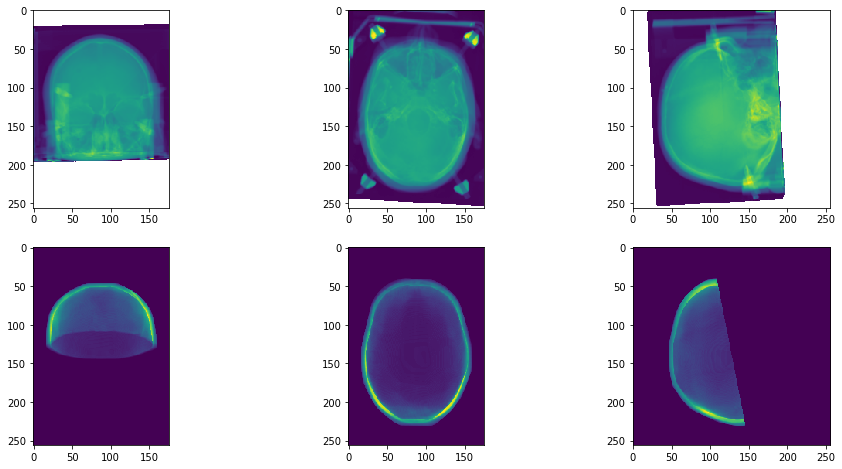

In [104]:
# Plot original CT vs segmented
axes = vis.compare_filtered_original(preop_CT_data, voxel_rem);

Text(0.5, 0, 'z')

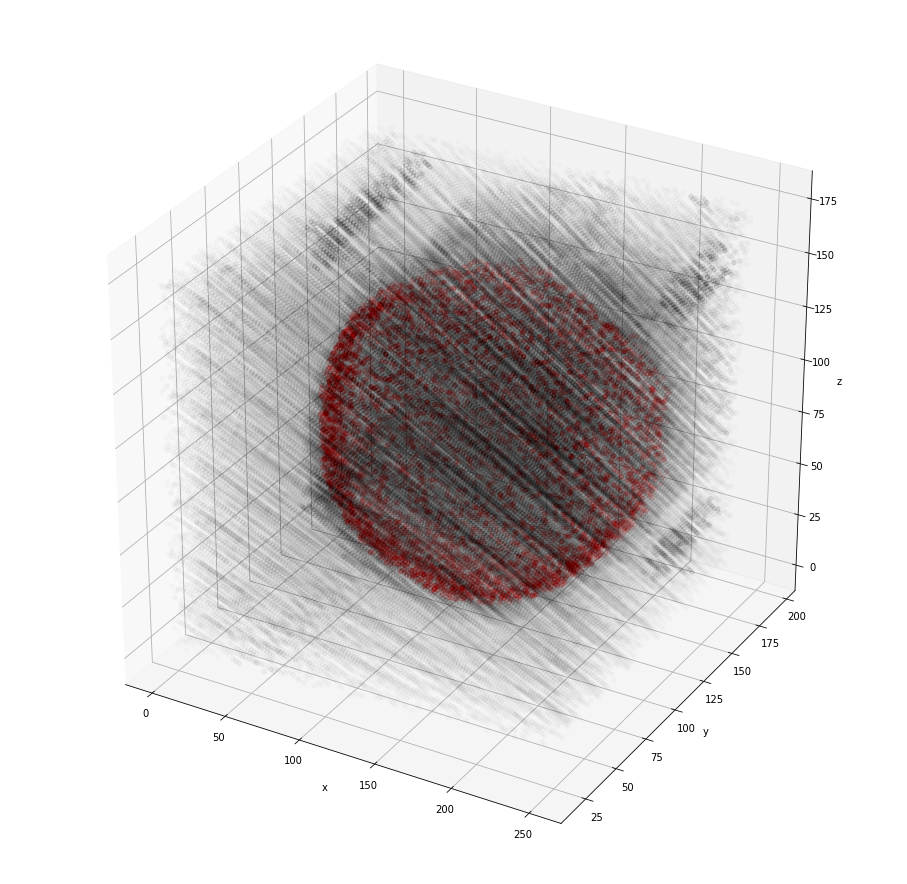

In [101]:
ax = vis.quick_plot_3D(
    lower_removed,
    is_long=True,
    is_norm=True,
    alpha_max=0.5,
    base_color=(1,0,0)
)
vis.quick_plot_3D(
    long_data,
    is_long=True,
    is_norm=True,
    alpha_max=0.2,
    step_size=50,
    ax=ax
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Saving feature space CT using affine and header from original


In [96]:
feature_CT = nib.nifti2.Nifti2Image(voxel_rem, preop_CT.affine, header=preop_CT.header)

sizeof_hdr should be 540; set sizeof_hdr to 540


In [97]:
file_name = os.path.join(
    'output',
    subject + '_skull.nii'
)
nib.nifti2.save(feature_CT, file_name)